In [1]:
%matplotlib inline

goal:

an analysis with specific papers.
look at interdisciplinary papers, within discipline papers, and any
new post-hoc statistics that you think could be interesting.  for how
to do this, see our papers on collaborative topic modeling and my talk
about it (all on my website).  ask me if you are confused how to do
this.  i'm also interested in how this model fails on this data.  (we
know it must.)

a super thorough look at
this model would also consider the held out predictions and specific
users.  you would understand their interests via their clicks, and how
the model has captured or not captured them.

In [29]:
# replicate the functionality of explore-coll-msd-tm.R for posterity and general ease of use
import numpy as np
import cPickle as pickle
import pandas as pd
import matplotlib
import h5py
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
from IPython.display import display



#fitPath = "/scratch/shared/music_project/jaan/ctpf-fits/collabtm/src/nusers1128835-ndocs202994-nvocab256-k50-batch-bin-vb-fa-ldainit/"

# fit path
fitPath = '/home/waldorf/altosaar/projects/arxiv/fit/ctpf-stagewise/'

# output file
fName = fitPath + 'arxiv-categories-ctpf-2.txt'

# maps
in_dir = '/home/statler/lcharlin/arxiv/dat/dataset_2003-2012_clean/'
id2arxiv_info = pd.read_csv(in_dir + 'items_arxiv_info.tsv', header=None, delimiter='\t', names=['arxiv_id', 'categories', 'title', 'date'])

check that we have the right categories in the map:

In [7]:
document_category_dummies = id2arxiv_info['categories'].str.join(sep='').str.get_dummies(sep=' ')
category_list = list(document_category_dummies.columns)

In [8]:
observed_categories = document_category_dummies.as_matrix().astype(np.float32)

In [9]:
topic2category = {k:category for k, category in enumerate(category_list)}

# NB: here theta = topic matrix, but in my fits, theta = user prefs matrix!

In [17]:
# # load theta
# for fixed (observed) theta the code adds a small prior value (0.0308...) to each entry
# tName = fitPath + 'theta.tsv'
# # skip first two cols, and first row
# theta = pd.read_csv(tName, delimiter='\t', header=None).iloc[0:,2:]

# this is the fixed theta (according to arxiv category)
fitFile = fitPath + 'fit.h5'
h5f = h5py.File(fitFile, 'r')
theta_t = h5f['Ebs_t'][:]
epsilon_t = h5f['Eba_t']
beta_t = h5f['Et_t']
#theta = observed_categories #pickle.load(open(tName, 'rb'))#pd.read_csv(tName, delimiter=' ', header=None)

KeyError: "Unable to open object (Object 'ebs_t' doesn't exist)"

In [19]:
theta = observed_categories

In [20]:
#theta = theta.as_matrix()
# normalize
# def normalizeRow(row):
#     return row / np.sum(row)
#theta.apply(normalizeRow, axis=0)

# num topics
k = len(theta[0])

# load epsilon
eName = '/home/waldorf/altosaar/projects/arxiv/fit/ctpf-stagewise/Eba-ie-epsilon.pkl'

# skip first 2 cols
epsilon = pickle.load(open(eName, 'rb'))#pd.read_csv(eName, delimiter='\t', header=None).iloc[0:,2:]

In [21]:
#epsilon = epsilon.as_matrix()

# load id2word
#mapName = '/scratch/shared/music_project/jaan/lda-fits/dat/id2word.pickle'
#id2word = pickle.load(open(mapName, 'rb'))

th_ep = theta + epsilon
th_ep_rs = np.sum(th_ep,axis=1)

In [22]:
id2arxiv_info.index = range(0, len(id2arxiv_info))

In [23]:
id2item_dict = id2arxiv_info.to_dict()

id2title = id2item_dict['title']
#id2title[0] = 'dummy title'
normth = theta

now we're ready to check if the observed topics match what's in our article id to title/arxiv id map. it checks out:

In [24]:
print np.where(theta[3434] == 1)
print topic2category[np.where(theta[3434] == 1)[0][0]]

print id2title[3434]

(array([19, 26]),)
cond-mat.mes-hall
Effects of a Fluctuating Interface between a Superfluid and a Polarized Fermi Gas


In [25]:
topic2category[26], topic2category[19]

('cond-mat.supr-con', 'cond-mat.mes-hall')

In [26]:
print th_ep.shape, th_ep_rs.shape

(806139, 166) (806139,)


In [27]:
# number of articles in category 0.
np.where(normth[:,0] > 0)[0].shape

(47,)

In [30]:
#working
def similarArticles(docId, theta, n):
    sqrt_normed_theta = np.sqrt(normth[docId])
    a = np.sum(np.power(np.sqrt(normththeta) - sqrt_normed_theta,2),axis=1)
    # this was in reverse
    top = np.argsort(a)
    for topId in top[0:n]:
        print "%0.3f  %s" %(a[topId],id2title[topId])

#working
def topArticles(k,normth=normth,n=10):
    top = np.argsort(normth[:,k])[::-1]
    return ["%0.3f  %s" %(normth[topId,k],id2title[topId]) for topId in top[0:n]]
    #for topId in top[0:n]:
        #print "%0.3f  %s" %(normth[topId,k],id2title[topId]))
        
#working! mistake was that i added normalized theta to eps for th_ep.
def inFieldArticles(k,th_ep=th_ep,normth=normth,n=10,prop=0.15):
    ind = np.where(normth[:,k] > prop)
    th_ep_ind = th_ep[ind,k][0]
    top = np.argsort(th_ep_ind)[::-1]
    return ["%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
     #   print "%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) 
        
#working
def outFieldArticles(k, th_ep=th_ep, normth=normth, n=10, prop=0.05):
    ind = np.where(normth[:,k] < prop)
    th_ep_ind = th_ep[ind,k][0]
    top = np.argsort(th_ep_ind)[::-1]
    return ["%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
     #   print "%0.3f  %s" %(th_ep_ind[topId],id2title[ind[0][topId]])

#working
def interFieldArticles(k, rs = th_ep_rs, th_ep = th_ep, n = 10, prop = 0.15):
    ind = np.where(normth[:,k] > prop)
    rs_ind = rs[ind]
    th_ep_ind = th_ep[ind,k][0]
    score = rs_ind - th_ep_ind
    top = np.argsort(score)[::-1]
    return ["%0.3f  %s" %(score[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    #for topId in top[0:n]:
    #    print "%0.3f  %s" %(score[topId],id2title[ind[0][topId]])

In [31]:
with open(fName, 'wb') as f:
    print>>f, 'this fit is in: ' + fitPath + '\n'
    #print>>f, 'the dataset is in: ' + datasetPath + '\n'
    for k in range(0,len(theta[0] + 1)):
        print>>f, '\n--------------------------------\n'
        print>>f, 'category k = ' + str(topic2category[k]) + '\n'
        print>>f, 'random articles from category'
        topArt = topArticles(k)
        for line in topArt:
            print>>f, line
        print>>f,'\nin-field articles'
        inField = inFieldArticles(k)
        for line in inField:
            print>>f,line
        print>>f,'\nout-field articles'
        outField = outFieldArticles(k)
        for line in outField:
            print>>f,line
        print>>f,'\ninter-field articles'
        interField = interFieldArticles(k)
        for line in interField:
            print>>f,line

look at hep articles that are of most interest to cond-mat

In [32]:
category2topic = {v:k for k, v in topic2category.items()}

In [33]:
category2topic

{'acc-phys': 0,
 'adap-org': 1,
 'alg-geom': 2,
 'ao-sci': 3,
 'astro-ph': 4,
 'astro-ph.CO': 5,
 'astro-ph.EP': 6,
 'astro-ph.GA': 7,
 'astro-ph.HE': 8,
 'astro-ph.IM': 9,
 'astro-ph.SR': 10,
 'atom-ph': 11,
 'bayes-an': 12,
 'chao-dyn': 13,
 'chem-ph': 14,
 'cmp-lg': 15,
 'comp-gas': 16,
 'cond-mat': 17,
 'cond-mat.dis-nn': 18,
 'cond-mat.mes-hall': 19,
 'cond-mat.mtrl-sci': 20,
 'cond-mat.other': 21,
 'cond-mat.quant-gas': 22,
 'cond-mat.soft': 23,
 'cond-mat.stat-mech': 24,
 'cond-mat.str-el': 25,
 'cond-mat.supr-con': 26,
 'cs.AI': 27,
 'cs.AR': 28,
 'cs.CC': 29,
 'cs.CE': 30,
 'cs.CG': 31,
 'cs.CL': 32,
 'cs.CR': 33,
 'cs.CV': 34,
 'cs.CY': 35,
 'cs.DB': 36,
 'cs.DC': 37,
 'cs.DL': 38,
 'cs.DM': 39,
 'cs.DS': 40,
 'cs.ET': 41,
 'cs.FL': 42,
 'cs.GL': 43,
 'cs.GR': 44,
 'cs.GT': 45,
 'cs.HC': 46,
 'cs.IR': 47,
 'cs.IT': 48,
 'cs.LG': 49,
 'cs.LO': 50,
 'cs.MA': 51,
 'cs.MM': 52,
 'cs.MS': 53,
 'cs.NA': 54,
 'cs.NE': 55,
 'cs.NI': 56,
 'cs.OH': 57,
 'cs.OS': 58,
 'cs.PF': 59,
 'cs.

try to look at papers in hep that are popular in cond-mat

In [49]:
def betweenFieldArticles(cat1, cat2, normth = normth, ep = epsilon, n = 10, prop = 0.15):
    k1 = category2topic[cat1]
    k2 = category2topic[cat2]
    # article indices in topic k1
    ind = np.where(normth[:,k1] > prop)
    
    # popularity of articles in k1 in topic k2
    ep_ind = ep[ind,k2][0]
    
    # most popular articles with respect to k2 that are in k1
    top = np.argsort(ep_ind)[::-1]
    betweenField = ["%0.3f  %s" %(ep_ind[topId],id2title[ind[0][topId]]) for topId in top[0:n]]
    for line in betweenField:
        print line

betweenFieldArticles('hep-ph', 'cond-mat', n=20)


5.032  Drawing Feynman Diagrams with LaTeX and Metafont
4.223  Some Basic Aspects of Fractional Quantum Numbers
3.517  Non-Perturbative Renormalization Flow in Quantum Field Theory and Statistical Physics
3.015  Evaluating Sums over the Matsubara Frequencies
2.983  Fields
2.668  Wick's Theorem at Finite Temperature
2.635  A Goldstone Boson Primer
2.349  Nonperturbative XY-model approach to strong coupling superconductivity in two and three dimensions
2.188  Quantum Field Theory at Finite Temperature: An Introduction
2.165  What exactly is a Skyrmion?
2.140  Theta-terms in nonlinear sigma-models
2.002  Symmetry breaking and defects
1.962  Introduction to Monte Carlo methods
1.932  Nonlinear sigma model approach for phase disorder transitions and the pseudogap phase in chiral Gross-Neveu, Nambu-Jona-Lasinio models and strong-coupling superconductors
1.900  The Exact Renormalisation Group and Approximate Solutions
1.872  Superfluid analogies of cosmological phenomena
1.849  Vortex Formati

^ this is very cool! it picks out:

80117.000  Superfluid analogies of cosmological phenomena

76419.000  Quantum Field Theory at Finite Temperature: An Introduction

47495.000  The Condensed Matter Physics of QCD

88740.000  Goldstone and Pseudo-Goldstone Bosons in Nuclear, Particle and Condensed-Matter Physics

73550.000  Symmetry breaking and defects

as being of interest to both high energy and condensed matter people, which is what i expected!

the next step could be:
 
* use the exposure model to account for whether or not physicists actually considered the articles in ML to get better performance in these types of tasks. right now there's still some junk

In [50]:
betweenFieldArticles('stat.ML', 'hep-ex', n=20)

0.734  Machine learning approach to inverse problem and unfolding procedure
0.618  Semi-Supervised Anomaly Detection - Towards Model-Independent Searches of New Physics
0.210  Dynamic quantum clustering: a method for visual exploration of structures in data
0.204  Classifying extremely imbalanced data sets
0.105  PDE-Foam - a probability-density estimation method using self-adapting phase-space binning
0.054  Isoelastic Agents and Wealth Updates in Machine Learning Markets
0.051  BAMBI: blind accelerated multimodal Bayesian inference
0.035  Clustering Stability: An Overview
0.033  A Privacy-Aware Bayesian Approach for Combining Classifier and Cluster Ensembles
0.028  Classification by Set Cover: The Prototype Vector Machine
0.024  Generalised elastic nets
0.020  Sparse matrix-variate Gaussian process blockmodels for network modeling
0.020  Fast ABC-Boost for Multi-Class Classification
0.017  Near-Optimal Target Learning With Stochastic Binary Signals
0.016  Self-configuration from a Ma

In [51]:
betweenFieldArticles('stat.ML', 'stat.ML', n=20)

4.190  High-dimensional regression with noisy and missing data: Provable guarantees with nonconvexity
4.106  Noisy matrix decomposition via convex relaxation: Optimal rates in high dimensions
3.928  Fast global convergence of gradient methods for high-dimensional statistical recovery
3.659  Structured Variable Selection with Sparsity-Inducing Norms
3.296  Matrix Completion from a Few Entries
3.172  A Scalable Bootstrap for Massive Data
3.020  An Introduction to Conditional Random Fields
2.705  A Spectral Algorithm for Latent Dirichlet Allocation
2.698  Ergodic Mirror Descent
2.687  Distributed Matrix Completion and Robust Factorization
2.569  Stochastic Variational Inference
2.538  A survey of statistical network models
2.496  Revisiting k-means: New Algorithms via Bayesian Nonparametrics
2.492  A General Framework of Dual Certificate Analysis for Structured Sparse Recovery Problems
2.488  Optimization with Sparsity-Inducing Penalties
2.481  Stochastic optimization and sparse statistic

In [58]:
betweenFieldArticles('stat.ML', 'physics.data-an', n=20)

1.156  Edit wars in Wikipedia
0.849  PDE-Foam - a probability-density estimation method using self-adapting phase-space binning
0.814  BAMBI: blind accelerated multimodal Bayesian inference
0.790  Entropy-Based Search Algorithm for Experimental Design
0.587  Machine learning approach to inverse problem and unfolding procedure
0.580  Dynamic quantum clustering: a method for visual exploration of structures in data
0.482  Instant Replay: Investigating statistical Analysis in Sports
0.472  A Very Fast Algorithm for Matrix Factorization
0.427  Proceedings of the 2011 New York Workshop on Computer, Earth and Space Science
0.422  Minimum Probability Flow Learning
0.398  Quantifying Causal Coupling Strength: A Lag-specific Measure For Multivariate Time Series Related To Transfer Entropy
0.336  Classifying extremely imbalanced data sets
0.326  Identifying Relevant Eigenimages - a Random Matrix Approach
0.258  Maximum Joint Entropy and Information-Based Collaboration of Automated Learning Machi

look up stephan's paper

In [59]:
id2arxiv_info[id2arxiv_info.arxiv_id == '1008.0468']

,arxiv_id,categories,title,date
589400,1008.0468,cond-mat.quant-gas,Equilibration rates and negative absolute temp...,2010-08-03


In [60]:
epsilon_categories = pd.DataFrame(data=epsilon, columns=category_list)

In [61]:
np.where(theta[589400] > 0)

(array([22]),)

In [62]:
topic2category[22]

'cond-mat.quant-gas'

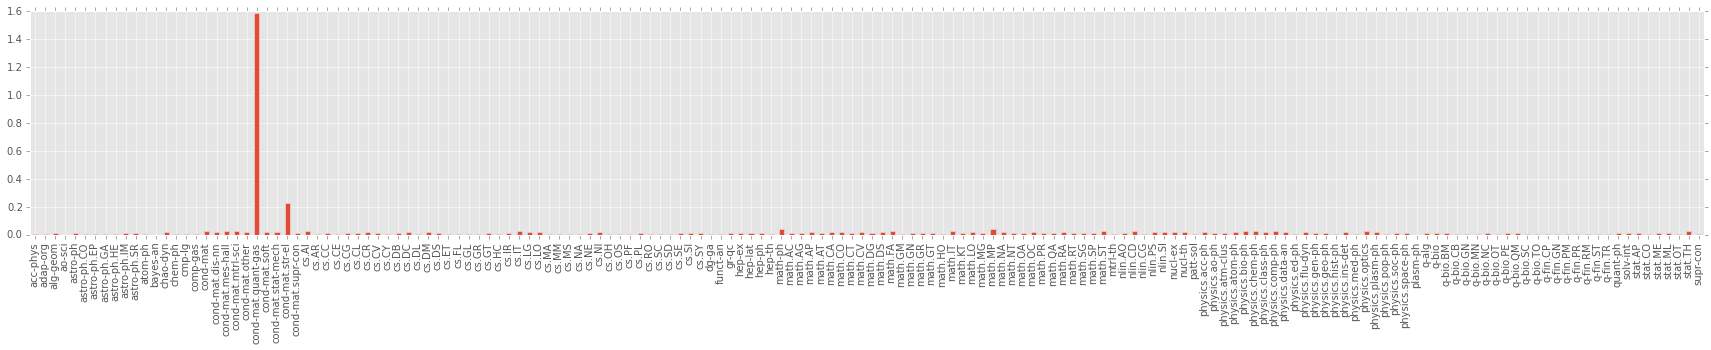

In [63]:
epsilon_categories.loc[589400].plot(kind='bar', figsize=(30, 4))

this is better than the earlier fit - it picks out strongly correlated electronic systems as a category of interest.

look at sachdev / ads cft

In [64]:
id2item = id2arxiv_info

In [65]:
id2item[id2item.arxiv_id == '1002.2947']

,arxiv_id,categories,title,date
32111,1002.2947,hep-th cond-mat.str-el,Condensed matter and AdS/CFT,2010-02-16


In [66]:
np.where(theta[32111]>0)

(array([25, 73]),)

In [67]:
topic2category[73]

'hep-th'

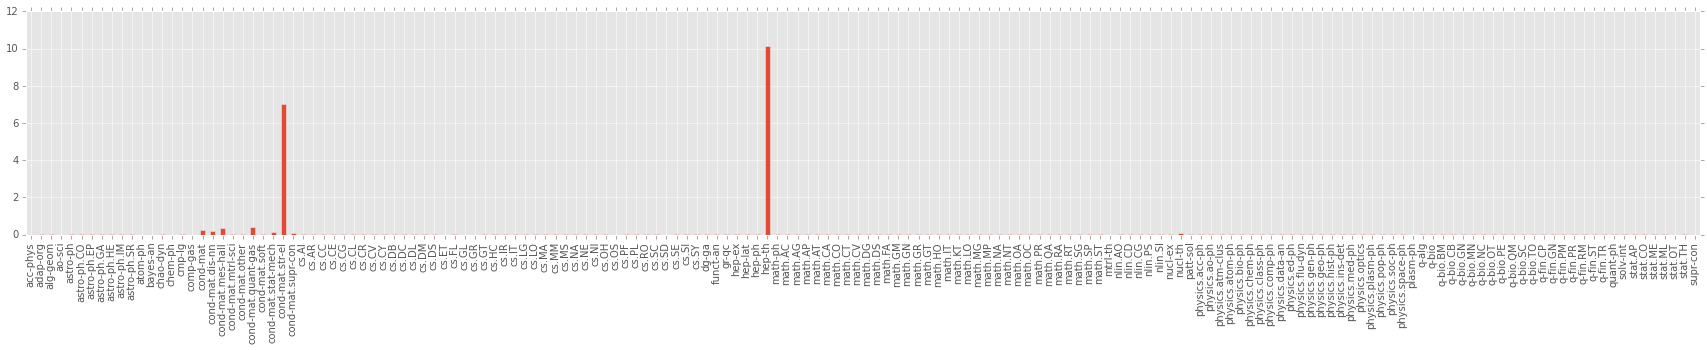

In [68]:
epsilon_categories.loc[32111].plot(kind='bar', figsize=(30, 4))

it captures some extraneous interest, but mostly epsilon is large in the categories corresponding to theta

look at altland & zirnbauer

In [69]:
id2item[id2item.arxiv_id == 'cond-mat/9602137']

,arxiv_id,categories,title,date
247209,cond-mat/9602137,cond-mat,Novel Symmetry Classes in Mesoscopic Normal-Su...,1996-02-27


In [70]:
def plot_eps(doc_id):
    
    display(id2item.iloc[doc_id])
    
    topic = np.where(theta[doc_id]>0)[0][0]

    #print topic2category[topic]

    epsilon_categories.loc[doc_id].plot(kind='bar', figsize=(30, 4))

* nb: epsilon can't be strictly zero because the likelihood could be zero, but there is a positive prior contribution too.

arxiv_id                                       cond-mat/9602137
categories                                             cond-mat
title         Novel Symmetry Classes in Mesoscopic Normal-Su...
date                                                 1996-02-27
Name: 247209, dtype: object

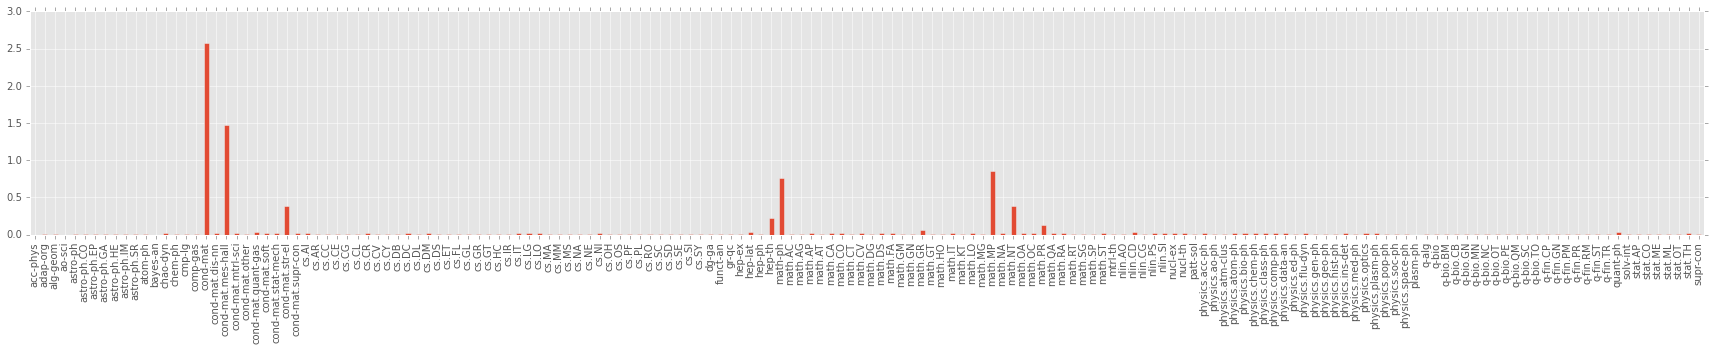

In [72]:
plot_eps(247209)

* try to back up this 'anomalous' behaviour by estimating the number of citations we'd expect.

try to look at most 'popular' papers in condensed matter (epsilon should correspond to clicks?)

In [94]:
def get_top_articles_eps(category, n=10):
    top = epsilon_categories.sort(columns=category, ascending=False)[category]

    top = top[0:n]

    for ID, eps in zip(top.index, top):
        print '{:0.2f}\t {}'.format(eps, id2title[ID])

In [96]:
get_top_articles_eps('cond-mat')

15.10	 One-Dimensional Fermi liquids
15.02	 Path Integral Methods and Applications
13.30	 The Hubbard Model: Some Rigorous Results and Open Problems
10.84	 Bosonization for Beginners --- Refermionization for Experts
8.62	 The one-dimensional Hubbard model: A reminiscence
8.41	 Quantum phase transitions
8.21	 A practical guide to computer simulations
8.14	 An Introduction into the Feynman Path Integral
7.08	 An introduction to bosonization
6.99	 Conformal Field Theory Approach to the Kondo Effect


arxiv_id                                           math/0311087
categories                                      math.DG math.PR
title         Neighbourhoods of independence for random proc...
date                                                 2003-11-06
Name: 643098, dtype: object

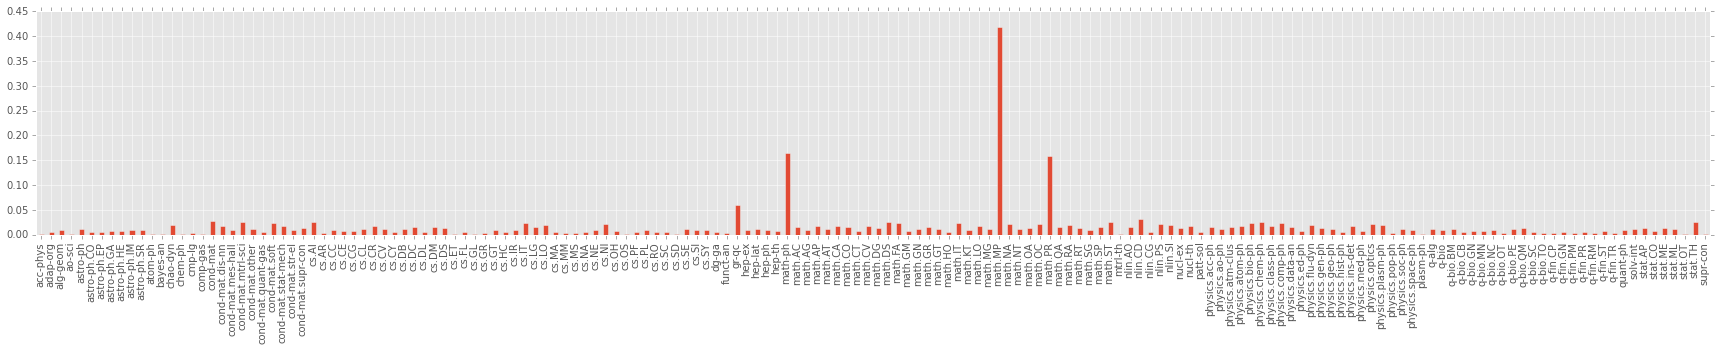

In [97]:
plot_eps(643098)

this is an article that attracts people in condensed matter and unusually so

arxiv_id                                              1206.0390
categories                                                gr-qc
title         Cauchy problem with data on a characteristic c...
date                                                 2012-06-02
Name: 571709, dtype: object

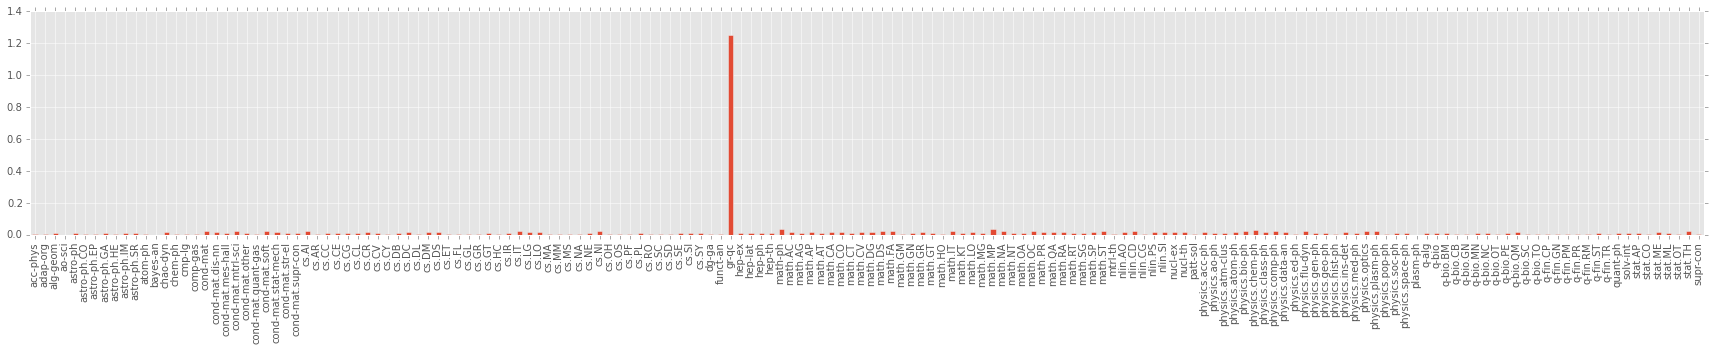

In [98]:
plot_eps(571709)

look at norm of epsilon to see if it correlates to popularity

In [99]:
epsilon_norm = np.sqrt(np.square(epsilon_categories).sum(axis=1))

In [100]:
epsilon_norm.sort(ascending=False)

In [125]:
display(id2arxiv_info.iloc[2272].categories)

'hep-ex hep-ph'

In [129]:
for ID, eps in zip(epsilon_norm[0:10].index, epsilon_norm[0:10]):
    print '{:0.2f} {}\t {}'.format(eps, id2arxiv_info.iloc[ID].categories, id2title[ID])

56.95 hep-ex hep-ph	 Measurement of the neutrino velocity with the OPERA detector in the CNGS beam
52.66 hep-ph hep-ex hep-th	 A Supersymmetry Primer
52.46 math.DG	 The entropy formula for the Ricci flow and its geometric applications
47.29 hep-th gr-qc hep-lat hep-ph	 Large N Field Theories, String Theory and Gravity
45.99 hep-ex	 Invariant Mass Distribution of Jet Pairs Produced in Association with a W boson in ppbar Collisions at sqrt(s) = 1.96 TeV
43.73 hep-th	 Anti De Sitter Space And Holography
42.28 math.DG	 Ricci flow with surgery on three-manifolds
41.79 hep-th	 The Large N Limit of Superconformal Field Theories and Supergravity
38.52 astro-ph	 Wilkinson Microwave Anisotropy Probe (WMAP) Three Year Results: Implications for Cosmology
36.37 math.DG	 Finite extinction time for the solutions to the Ricci flow on certain three-manifolds


the proof of innocence is one of the most popular articles on the arxiv in terms of clicks (major press coverage, etc)

In [130]:
id2item[id2item.arxiv_id == '1204.0162']

,arxiv_id,categories,title,date
13057,1204.0162,physics.pop-ph physics.data-an,The Proof of Innocence,2012-04-01


arxiv_id                           1204.0162
categories    physics.pop-ph physics.data-an
title                 The Proof of Innocence
date                              2012-04-01
Name: 13057, dtype: object

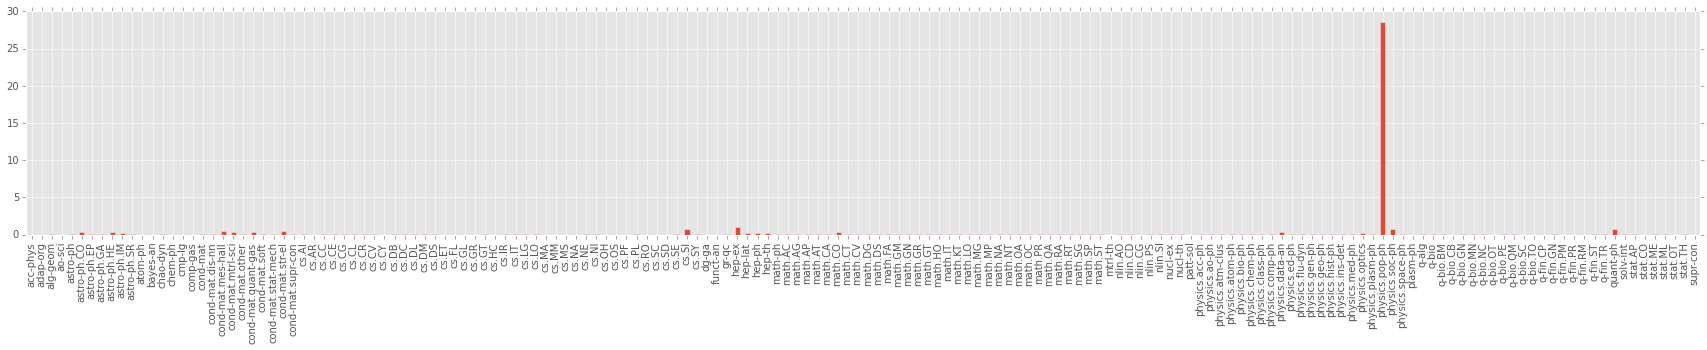

In [131]:
plot_eps(13057)

look at some highly-cited papers (via https://www.quora.com/What-are-some-of-the-most-cited-papers-from-arXiv)

one of the most cited papers in physics: 9711200

In [132]:
id2item[id2item.arxiv_id == 'hep-th/9711200']

,arxiv_id,categories,title,date
8176,hep-th/9711200,hep-th,The Large N Limit of Superconformal Field Theo...,1997-11-27


arxiv_id                                         hep-th/9711200
categories                                               hep-th
title         The Large N Limit of Superconformal Field Theo...
date                                                 1997-11-27
Name: 8176, dtype: object

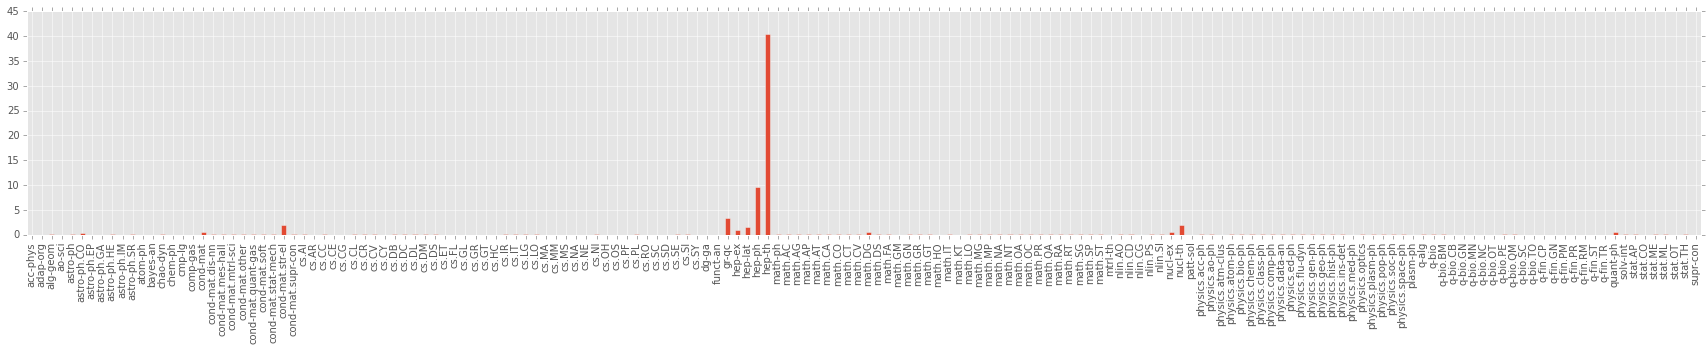

In [133]:
plot_eps(8176)

this is OK, but doesn't really capture inderdisciplinary interest.

In [134]:
lst = ['astro-ph/9812133', 'astro-ph/9805201', 'astro-ph/0302209']

In [135]:
idlist = []
for idx in range(0,len(lst)):
    idlist.append(id2item[id2item.arxiv_id == lst[idx]].index[0])

In [136]:
idlist

[5065, 15852, 104]

arxiv_id                                       astro-ph/9812133
categories                               astro-ph hep-ex hep-ph
title         Measurements of Omega and Lambda from 42 High-...
date                                                 1998-12-07
Name: 5065, dtype: object

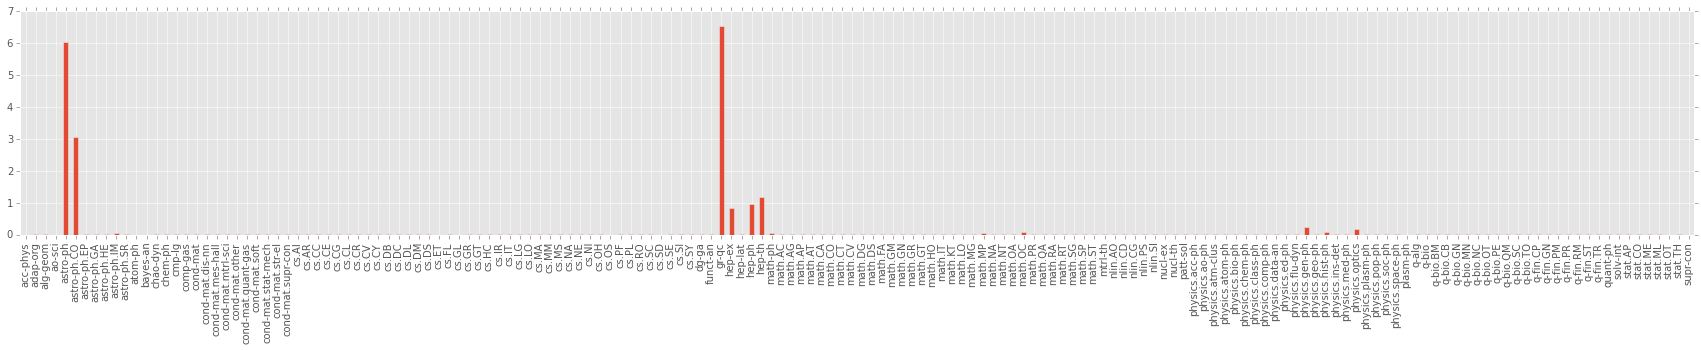

arxiv_id                                       astro-ph/9805201
categories                                             astro-ph
title         Observational Evidence from Supernovae for an ...
date                                                 1998-05-14
Name: 15852, dtype: object

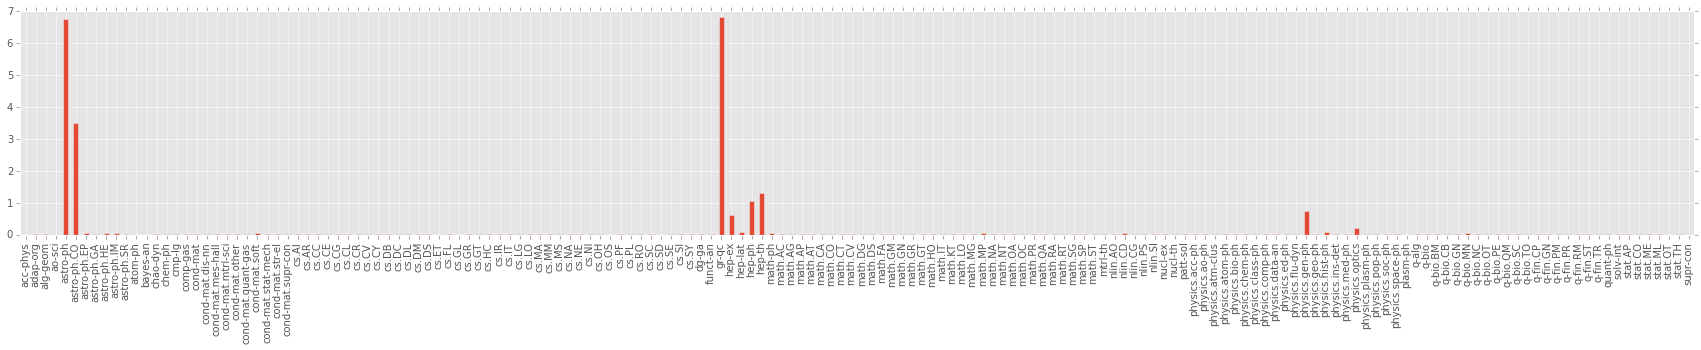

arxiv_id                                       astro-ph/0302209
categories                                             astro-ph
title         First Year Wilkinson Microwave Anisotropy Prob...
date                                                 2003-02-11
Name: 104, dtype: object

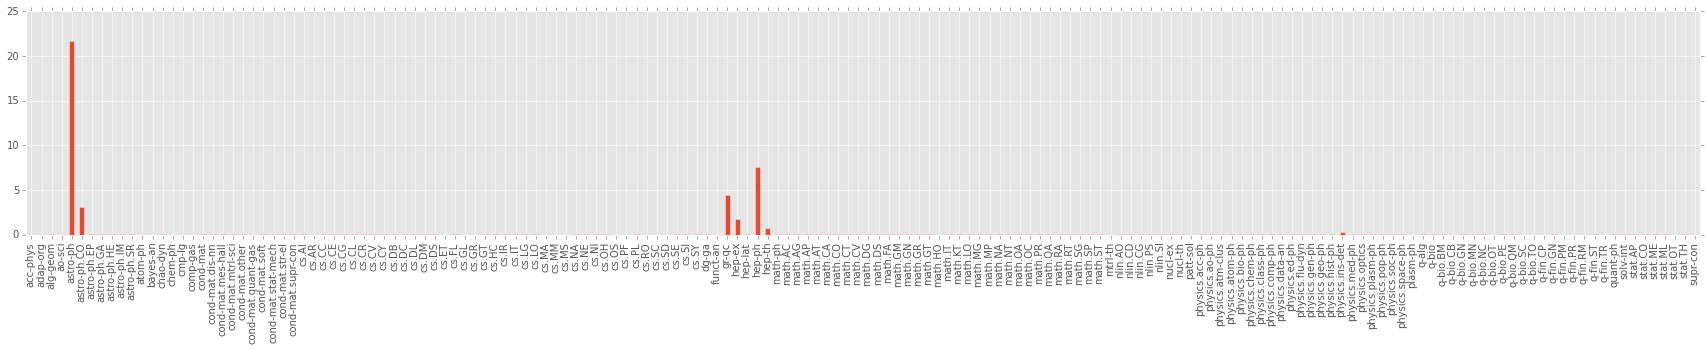

In [137]:
for idx in idlist:
    plot_eps(idx)
    plt.show()
    plt.close()

^ this is good: captures interest in the appropriate categories!

look at histogram for papers in categories

In [138]:
theta_categories = pd.DataFrame(data=theta, columns=category_list)

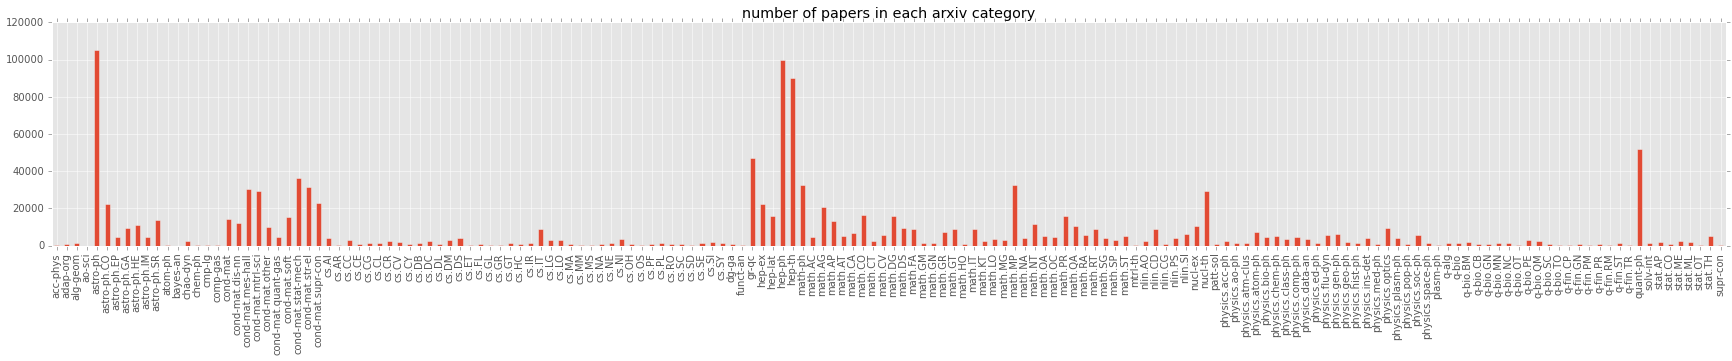

In [139]:
theta_categories.sum().plot(kind='bar',figsize=(30, 4), title='number of papers in each arxiv category')

which categories have the most 'surprise'? i.e., the highest average theta?

In [140]:
epsilon_describe = epsilon_categories.describe()

In [141]:
epsilon_describe

,acc-phys,adap-org,alg-geom,ao-sci,astro-ph,astro-ph.CO,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.IM,...,q-fin.TR,quant-ph,solv-int,stat.AP,stat.CO,stat.ME,stat.ML,stat.OT,stat.TH,supr-con
count,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,...,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000,806139.000000
mean,0.000397,0.004488,0.009155,0.000146,0.079975,0.034101,0.013193,0.025115,0.028822,0.012223,...,0.003425,0.065172,0.010417,0.012819,0.006291,0.014428,0.012262,0.000983,0.026668,0.001434
std,0.000172,0.002633,0.003966,0.000154,0.356219,0.199619,0.089457,0.135110,0.153835,0.067661,...,0.002365,0.328855,0.002438,0.018271,0.009281,0.016008,0.036973,0.000192,0.037994,0.000174
min,0.000392,0.004408,0.008935,0.000143,0.010505,0.004270,0.005480,0.007149,0.006170,0.008137,...,0.003335,0.008875,0.010198,0.012492,0.005958,0.013597,0.010399,0.000970,0.023884,0.001415
25%,0.000394,0.004436,0.008986,0.000144,0.010512,0.004272,0.005487,0.007156,0.006176,0.008154,...,0.003354,0.008891,0.010266,0.012557,0.005988,0.013659,0.010440,0.000976,0.023986,0.001423
50%,0.000395,0.004456,0.009027,0.000145,0.010572,0.004282,0.005496,0.007166,0.006194,0.008176,...,0.003368,0.008945,0.010320,0.012608,0.006010,0.013706,0.010470,0.000980,0.024067,0.001429
75%,0.000398,0.004489,0.009095,0.000146,0.010960,0.004378,0.005530,0.007242,0.006299,0.008302,...,0.003391,0.009124,0.010420,0.012692,0.006048,0.013787,0.010523,0.000986,0.024213,0.001439
max,0.099943,1.437330,0.878982,0.068097,37.045288,23.066647,7.863973,7.654246,9.656222,10.899772,...,0.656660,27.446476,0.883993,13.902493,1.344002,2.641249,4.189933,0.108122,4.693662,0.113408


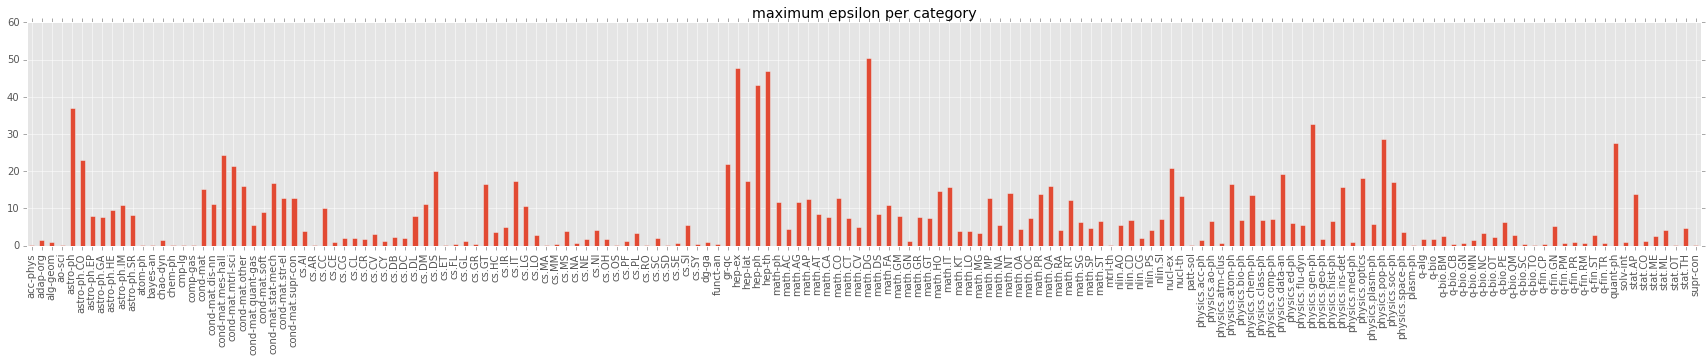

In [142]:
epsilon_describe.iloc[7,:].plot(kind='bar', figsize=(30, 4), title='maximum epsilon per category')

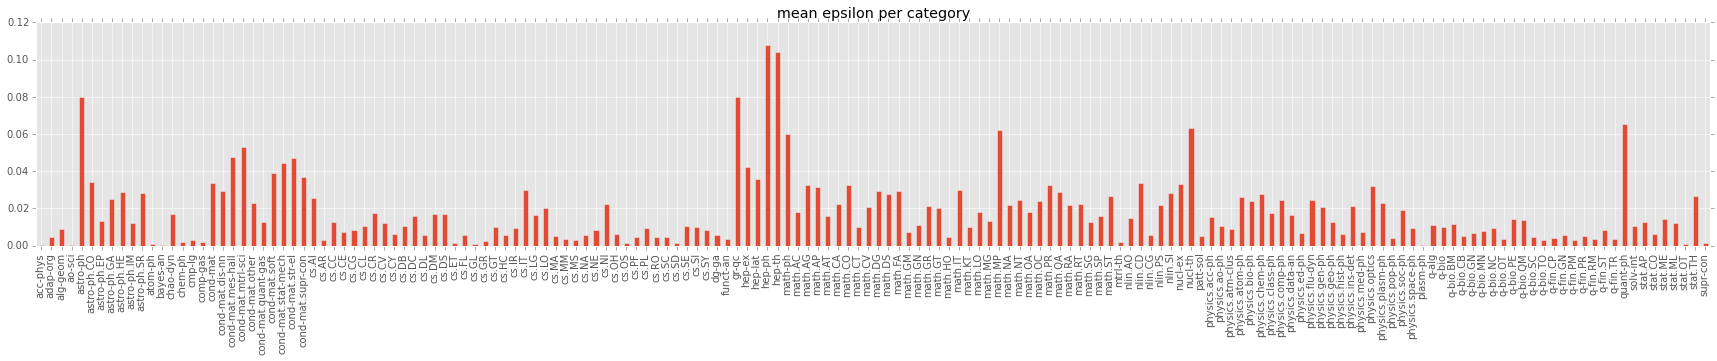

In [143]:
epsilon_describe.iloc[1,:].plot(kind='bar', figsize=(30, 4), title='mean epsilon per category')

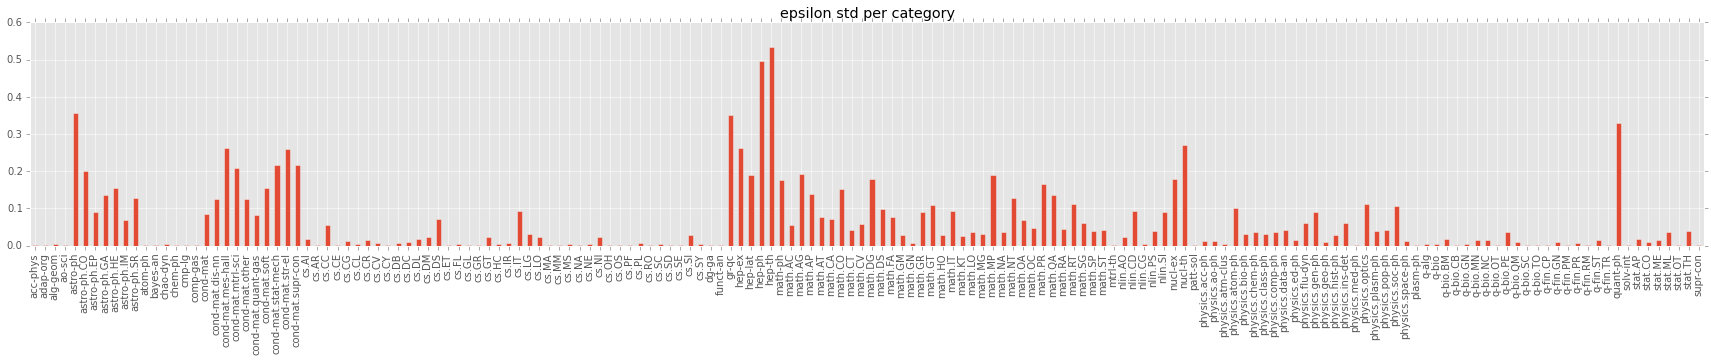

In [144]:
epsilon_describe.iloc[2,:].plot(kind='bar', figsize=(30, 4), title='epsilon std per category')

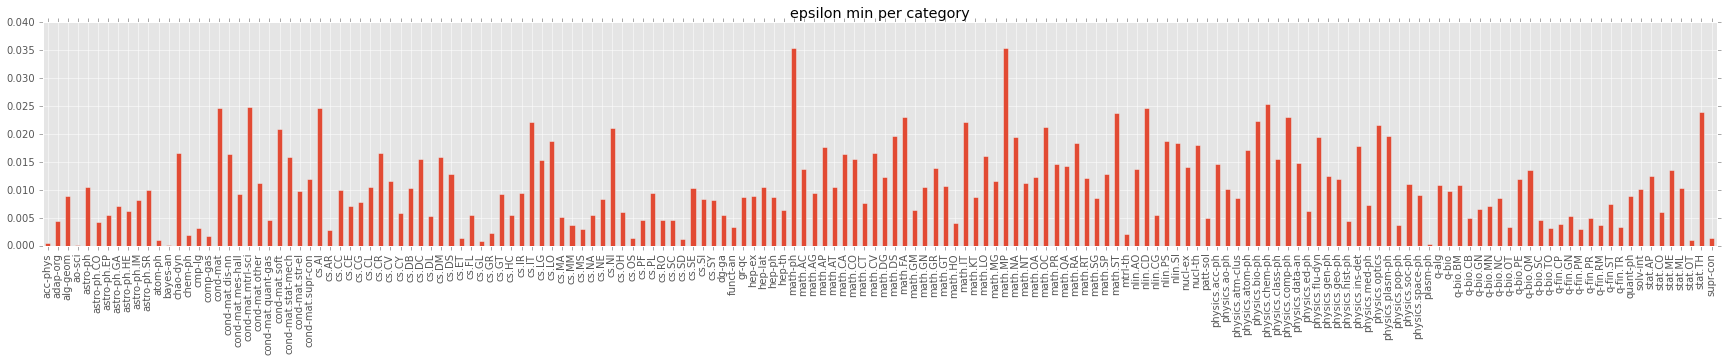

In [145]:
epsilon_describe.iloc[3,:].plot(kind='bar', figsize=(30, 4), title='epsilon min per category')

plot epsilon min and number of papers per category

In [146]:
eps_min = epsilon_describe.iloc[3,:]

In [147]:
num_articles_per_category = theta_categories.sum()

In [148]:
eps_min_and_num = pd.concat([eps_min, num_articles_per_category], axis=1).T

In [149]:
eps_min_and_num.index = ['min', 'num_articles']

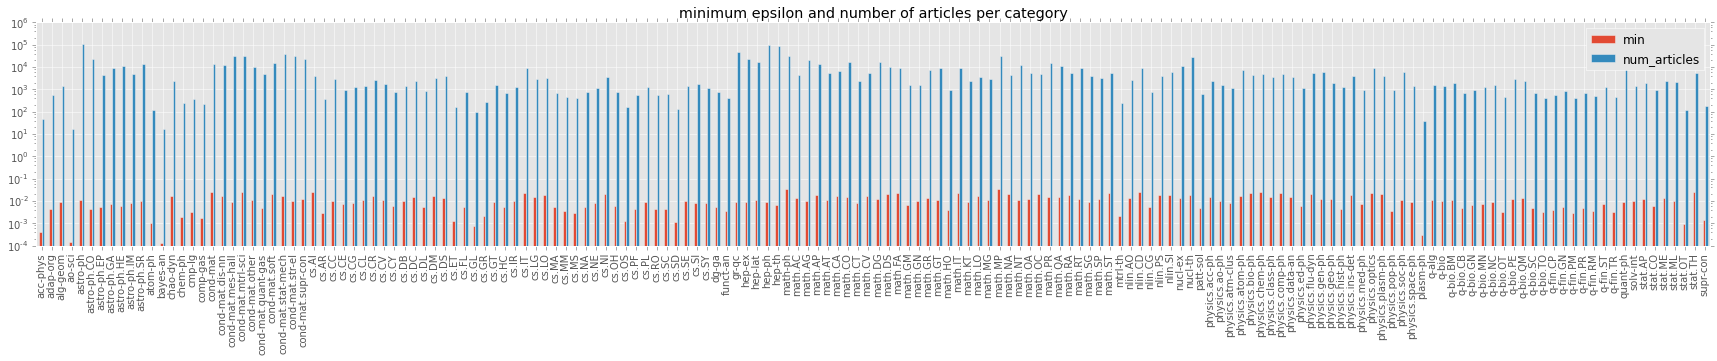

In [150]:
eps_min_and_num.T.plot(kind='bar', figsize=(30, 4), title='minimum epsilon and number of articles per category', logy=True)